<a href="https://colab.research.google.com/github/debanjan02/BreakHis/blob/master/raw/BreakHis_40X_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from sklearn.cluster import KMeans, estimate_bandwidth, MeanShift
from glob import glob
import cv2
import fnmatch
% matplotlib inline

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
x = np.load('/content/drive/My Drive/project/x_BreakHis_40.npy')
y = np.load('/content/drive/My Drive/project/y_BreakHis_40_bin.npy')

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 2)
y_valid = to_categorical(y_valid, num_classes = 2)

In [0]:
import keras
#import keras.metrics
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU 
from keras.applications.inception_v3 import InceptionV3
input_tensor = Input(shape=(299,299,3))
base_model = InceptionV3(input_tensor = input_tensor, include_top = False, pooling = 'average')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(2, activation = 'softmax')(x)
model = Model(base_model.input,x)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, 149, 149, 32) 96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 149, 149, 32) 0           batch_normalization_471[0][0]    
__________________________________________________________________________________________________
conv2d_472

In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot

In [0]:
!pip install graphviz

In [0]:
from keras.utils import plot_model
plot_model(model)

In [0]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='/content/drive/My Drive/project/model_check_path_BreakHis_40_bin_inception_v3',
                      monitor="val_acc", save_best_only=True, save_weights_only=False)
hist = model.fit(x_train,y_train,batch_size = 32, validation_split=0.2, epochs = 200, verbose=1, callbacks=[mcp])

Train on 3830 samples, validate on 958 samples
Epoch 1/200
3830/3830 [==============================] - 181s 47ms/step - loss: 0.2716 - acc: 0.8956 - val_loss: 3.5819 - val_acc: 0.5616
Epoch 2/200
3830/3830 [==============================] - 150s 39ms/step - loss: 0.1296 - acc: 0.9517 - val_loss: 6.8445 - val_acc: 0.4259
Epoch 3/200
3830/3830 [==============================] - 149s 39ms/step - loss: 0.0994 - acc: 0.9603 - val_loss: 0.1502 - val_acc: 0.9374
Epoch 4/200
3830/3830 [==============================] - 149s 39ms/step - loss: 0.0941 - acc: 0.9645 - val_loss: 0.2742 - val_acc: 0.8643
Epoch 5/200
3830/3830 [==============================] - 149s 39ms/step - loss: 0.1029 - acc: 0.9632 - val_loss: 1.1339 - val_acc: 0.8184
Epoch 6/200
3830/3830 [==============================] - 149s 39ms/step - loss: 0.0453 - acc: 0.9828 - val_loss: 0.0743 - val_acc: 0.9739
Epoch 7/200
3830/3830 [==============================] - 150s 39ms/step - loss: 0.0650 - acc: 0.9775 - val_loss: 0.5442 - val

KeyboardInterrupt: ignored

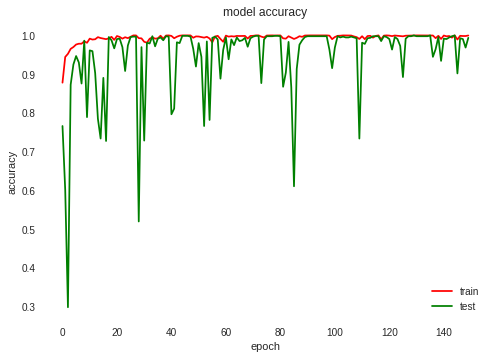

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['acc'], color='red')
ax.plot(hist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

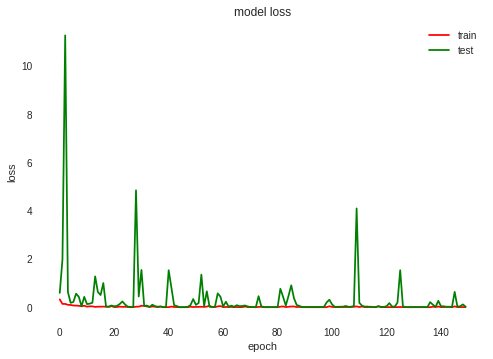

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['loss'], color='red')
ax.plot(hist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
model.load_weights('/content/drive/My Drive/project/model_check_path_BreakHis_100_octal_inception_v3')

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_valid)
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       372
           1       1.00      1.00      1.00       825

   micro avg       1.00      1.00      1.00      1197
   macro avg       1.00      1.00      1.00      1197
weighted avg       1.00      1.00      1.00      1197



In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

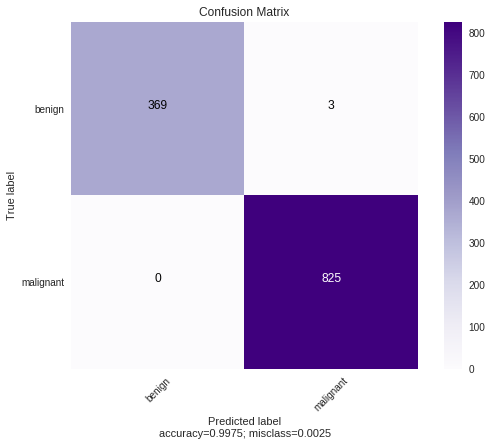

In [0]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      cmap = 'Purples',
                      normalize    = False,
                      target_names = ['benign', 'malignant'],
                      title        = "Confusion Matrix")